# Predicting hot water demand

Contributor: **Shashank Verma** (sverma28@wisc.edu)

**Inputs:** Hourly hot-water consumption data for a single household of 4 people (2 adults and 2 teenagers) in Cape Town, South Africa for the period 6 August 2017 to 5 August 2018.

**Objective:** Prediction of hot water demand for each hour of the period 6 August 2018 to 12 August 2018.

In [101]:
# Required Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt

## 1. Extracting data
### 1.1 Importing data

In [131]:
# Importing the data
df = pd.read_csv("data/hourly-hot-water-data.csv")
df.head()

,date,hour,hot_water_flow
0,2017-08-06,0,0.0
1,2017-08-06,1,0.5
2,2017-08-06,2,0.0
3,2017-08-06,3,0.0
4,2017-08-06,4,0.5


### 1.2 Re-organizing the Dataframe

In [132]:
# Converts the hour to appropriate format
def hour_format(hour):
    return hour + ':00:00'

# Creates a new date_time column that has both date and hour combined
df['date_time'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['hour'].astype(str).apply(hour_format))

# Returns weekday number for a given Datetime Object
def ret_weekday(x):
    return x.date_time.weekday()

# Adds a column for weekday in the order: [0:"Monday", 1:"Tuesday", 2:"Wednesday", 
# 3:"Thursday", 4:"Friday", 5:"Saturday", 6:"Sunday"]
df['weekday'] = df.apply(ret_weekday, axis=1)
df.head()

,date,hour,hot_water_flow,date_time,weekday
0,2017-08-06,0,0.0,2017-08-06 00:00:00,6
1,2017-08-06,1,0.5,2017-08-06 01:00:00,6
2,2017-08-06,2,0.0,2017-08-06 02:00:00,6
3,2017-08-06,3,0.0,2017-08-06 03:00:00,6
4,2017-08-06,4,0.5,2017-08-06 04:00:00,6


### 1.3 Check for missing values and Imputing them

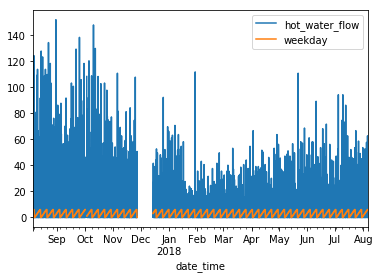

In [133]:
# Convention: df_ip: Interpolated Dataframe
df_ip = df.set_index('date_time')
df_ip = df_ip.asfreq(freq='H')

# Drop un-important columns
df_ip.drop(columns={"hour", "date"}, inplace=True)

# See plot for missing data.
df_ip.plot();

#### There is a very obvious gap in data. Among other missing values, the period from Late November 2017 to Mid December 2017 is the most prominent!

In [134]:
df_ip.isnull().sum()

hot_water_flow    457
weekday           457
dtype: int64

#### Seems like there are `457` missing hourly values. By exploratory analysis, I found that data has a strong weekly and daily seasonality. But weekends follow their own pattern! Hence we impute missing hot_water_flow values using the mean of the hot_water_flow on the same weekday number (Monday-Sunday).
For eg. missing value for "2017-10-01 19:00:00" will be imputed using the mean of all hot-water-values at hour 19:00:00 across all Sundays, since 2017-10-01 was a Sunday.

### 1.4 Interpolating over missing Data

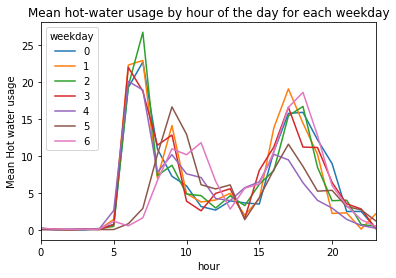

In [135]:
# This is the reference table for imputing missing values
df_fillers = df.pivot_table(index="hour", columns="weekday", values="hot_water_flow", aggfunc="mean")
ax = df_fillers.plot(title='Mean hot-water usage by hour of the day for each weekday');
ax.set_ylabel("Mean Hot water usage");

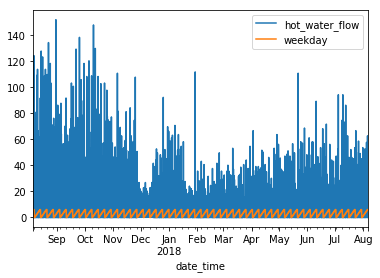

In [136]:
# Imputing missing values using the filler table. 
# This method iterates over NaN containing rows and fills them.
for index, row in df_ip.loc[df_ip.hot_water_flow.isnull()].iterrows():
    wd = index.weekday()
    hr = index.hour
    df_ip.loc[index].weekday = wd
    df_ip.loc[index].hot_water_flow = df_fillers.loc[hr, wd]
    
df_ip.plot();

We have imputed over the gap, but note since the above plot has 365*24 values, what we observe are the prominent outliers in the above plot. Admittedly mean may not be the best way to impute values in a seasonal time-series, but it turned out better than other interpolation methods in sklearn that I tested.

## 2. Exploratory Data Analysis <br>

### 2.1 Visualizing a week's data 

In [137]:
# Resetting index for convenience
df_ip = df_ip.reset_index()

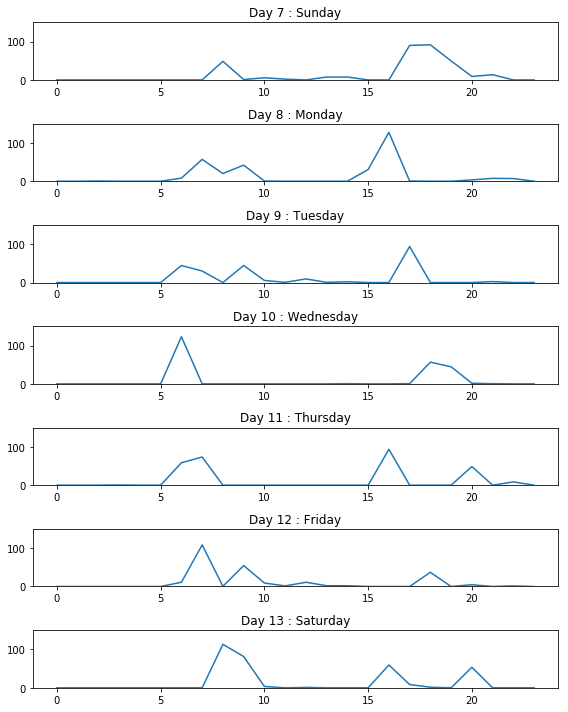

In [147]:
# For day-name extraction
day_list = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# We randomly select week 2 for visualization
week_num = 2
fig, axes = plt.subplots(nrows=7, ncols=1, sharex=False, figsize=(8,10))
day_range_start = 7 * (week_num - 1) # inclusive
day_range_end = 7 + day_range_start # exclusive


for nday in range(day_range_start, day_range_end):
    df_nday = df_ip.iloc[24*(nday): 24+24*(nday)]
    weekday = day_list[df_nday.iloc[0].date_time.weekday()]
    axes[nday%7].plot(df_nday.date_time.dt.hour, df_nday.hot_water_flow)
    axes[nday%7].set_title('Day '+str(nday)+ ' : ' + weekday)
    axes[nday%7].set_ylim([0, 150])
plt.tight_layout()
plt.show()

#### Analysis: We can observe a strick repetitiveness from Monday to Friday where the hot water usage peaks at around 6 am, and then at around 5-6pm in the evening too. These are timings when people usually go to work or come back from work! On Saturdays and Sundays these peaks are lagging probably because people tend to start their day later due to non-working days! <br>

The above analysis shows that we have both weekly and daily seasonality!

### 2.2 Summary Statistics

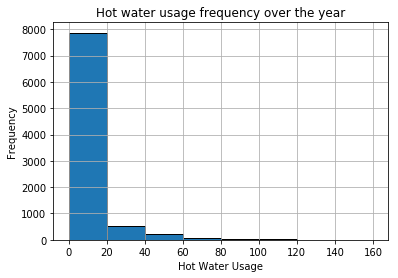

In [139]:
# Summary statistics (histogram) for the first year hot-water flow
ax = df_ip.hot_water_flow.plot.hist(bins=[0, 20, 40, 60, 80, 100, 120, 140, 160], ec='black', grid=True);
ax.set_xlabel("Hot Water Usage");
ax.set_title("Hot water usage frequency over the year");

#### Most instances of hot-water usage at a time only consumes 0-20 units of hot-water.  The histogram does not show Gaussian distribution and this is an indication of non-stationary time series data. This histogram is highly skewed to the right, meaning is has a large right tail!

### 2.3 STL Decomposition (Seasonal and Trend)

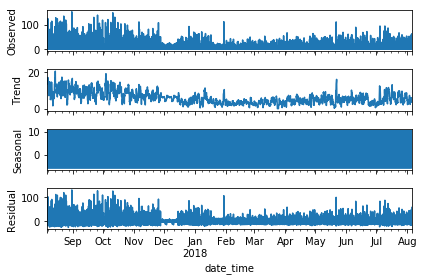

In [140]:
df_stl = df_ip.set_index('date_time', drop=True).drop(columns={"weekday"})

from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df_stl, model='additive');
result.plot();
plt.show();

#### It has a VERY strong daily and weekly seasonal component.  The trend doesn't seem linear, and the residuals does look like white Gaussian Noise except the portion we interpolated earlier where it is a linear'ish line.

#### Looking at the "Seasonal" plot for a 7 day period.

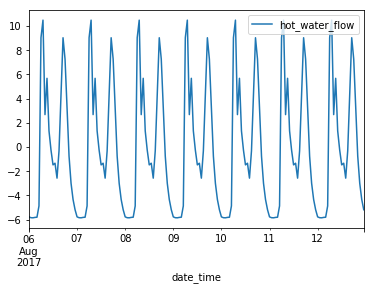

In [145]:
# 24*7 = 168
ax = result.seasonal.iloc[:168].plot();

#### This reinforces the previous inference that data is highly seasonal with daily and weekly seasonality.

## 3. Data Modeling Experiments
### Error Measure - Normalized Root Mean Squared

In [172]:
## Error Measure
from sklearn.metrics import mean_squared_error


# Function returns the normalized Root Mean Square Error
def nrmse(y_actual, y_predicted):
    rmse = np.sqrt(mean_squared_error(y_actual, y_predicted))
    return rmse/np.std(y_actual)

### 3.1 Seasonal ARIMA Model

#### 3.1.1 ACF / PACF Plots

In [157]:
df_arima = df_ip.copy()

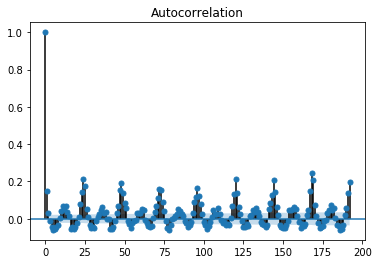

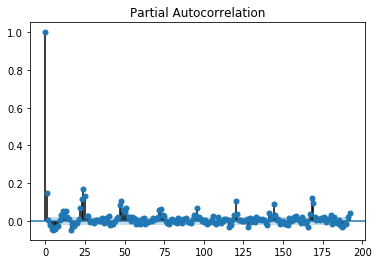

In [159]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df_arima.hot_water_flow, lags=192);
plt.show();

plot_pacf(df_arima.hot_water_flow, lags = 192);
plt.show()

#### ACF/PACF plots show auto-correlation peaks on 24 hr and 168 (24*7) hour intervals. This again indicated daily and weekly seasonality.

#### 3.1.3 Train-Test data selection
We train on the whole 12 months and plot our prediction week values against the same week from last year

In [169]:
# Choosing our training set as the whole 12 month period
df_train = df_arima

# Out `dummy` test-set is the period 7 August 2017 to 13 August 2017 (The Monday-Sunday week to be predicted from last year)
df_test = df_arima.loc[(df_arima.date_time >= dt.datetime(2017, 8, 7, 0, 0, 0)) & (df_arima.date_time < dt.datetime(2017, 8, 14, 0, 0, 0))]

#### 3.1.3 AutoARIMA Grid Search for most optimal Seasonal ARIMA parameters
We use daily seasonal frequency (m=24), as weekly frequency (m=168) SARIMA grid-search crashed my computer (twice!)

In [ ]:
from pmdarima.arima import auto_arima

model = auto_arima(df_train.hot_water_flow, trace=True, error_action='ignore', suppress_warnings=True, m=24, seasonal=True,
                  stepwise=True)

#### Running auto_arima frequently can be computationally very expensive. But from previous runs we we know that ARIMA(1, 0 , 2) + Seasonal(0, 1, 2, 24) is a good match for our data. The seasonal differencing of "1" will make the time-series stationary! We run ARIMA on optimal paramters obtained from grid-search.

#### 3.1.4 Model fitting and prediction using optimal ARIMA Parameters

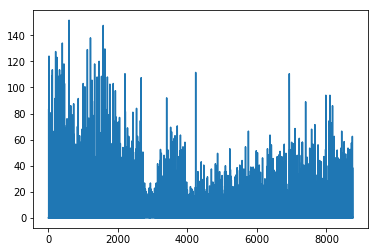

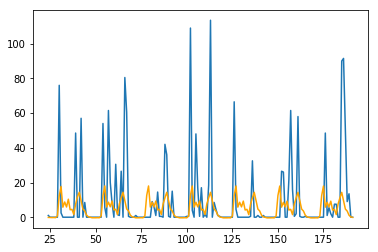

In [170]:
from pmdarima.arima import ARIMA

model = ARIMA(order=(1, 0 ,2), seasonal_order=(0, 1, 2, 24))
model.fit(df_train.hot_water_flow)

forecast = model.predict(n_periods=len(df_test))
forecast = pd.DataFrame(forecast,index = df_test.index,columns=['Prediction'])

# plot the training data
plt.plot(df_train.hot_water_flow, label='Train')
plt.show()

# plot the obtained forecast against last year's data from similar week
plt.plot(df_test.hot_water_flow, label='Valid')
plt.plot(forecast, label='Prediction', color='orange')
plt.show()

In [177]:
# RMSE calculation
print("Normalized RMSE: ", nrmse(df_test.hot_water_flow.values, forecast.values))

Normalized RMSE:  0.9603692974383339


### 3.2 Prophet Forecasting
Prophet is a new time-series forecasting framework by Facebook.

In [179]:
# Training data selection - Same as ARIMA

# Choosing our training set as the whole 12 month period
df_train = df_ip

# Out `dummy` test-set is the period 7 August 2017 to 13 August 2017 (The Monday-Sunday week to be predicted from last year)
df_test = df_ip.loc[(df_ip.date_time >= dt.datetime(2017, 8, 7, 0, 0, 0)) & (df_ip.date_time < dt.datetime(2017, 8, 14, 0, 0, 0))]

In [180]:
from fbprophet import Prophet

# Preparing data
df_train_pr = df_train[['date_time', 'hot_water_flow']].copy()
df_train_pr = df_train_pr.rename(columns={"date_time":"ds", "hot_water_flow":"y"})

pr_model = Prophet()
pr_model.fit(df_train_pr)

future = pr_model.make_future_dataframe(periods=168, freq='H')
forecast = pr_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

/home/shashankv/anaconda3/envs/ml/lib/python3.6/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/home/shashankv/anaconda3/envs/ml/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


,ds,yhat,yhat_lower,yhat_upper
8923,2018-08-12 19:00:00,11.071368,-4.641377,28.034233
8924,2018-08-12 20:00:00,6.298457,-10.848575,22.851713
8925,2018-08-12 21:00:00,2.406041,-14.680909,19.486056
8926,2018-08-12 22:00:00,1.101380,-15.791187,17.494840
8927,2018-08-12 23:00:00,1.787886,-14.573645,17.957697


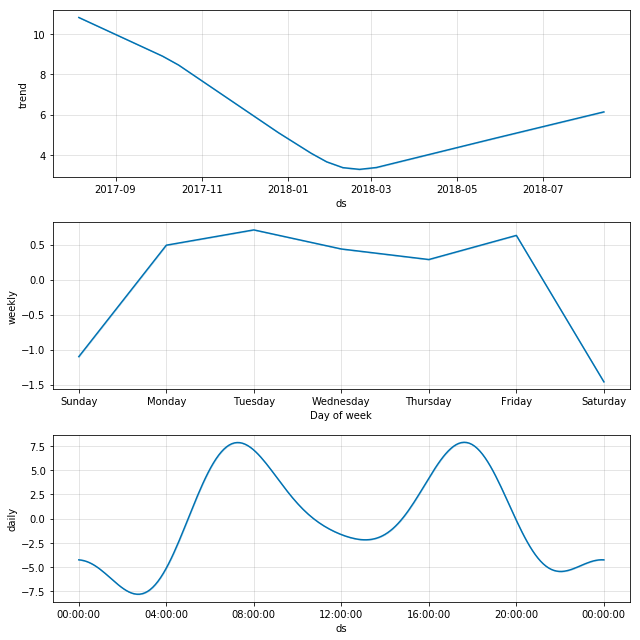

In [182]:
pr_model.plot_components(forecast);

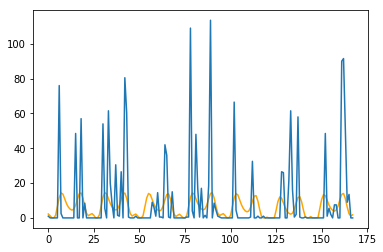

Normalized RMSE is: 0.9436089751340054


In [183]:
def neg_clip(val):
    if val < 0:
        val = 0
    return val

plt.plot(forecast.iloc[-168:].yhat.apply(neg_clip).values, label='Prediction', color='orange')
plt.plot(df_test.hot_water_flow.values, label='Valid')
plt.show()

print("Normalized RMSE is:", nrmse(df_test.hot_water_flow.values, forecast.iloc[-168:].yhat.apply(neg_clip).values ))

### 3.3 Ensemble Regression Methods

#### 3.3.1 Feature Preparation
This method will require us to use month, weekday and hour as features. Month value will be one-hot encoded.

In [194]:
df_em = df_ip.copy()
df_em['hour'] = df_em.date_time.dt.hour
df_em['month'] = df_em.date_time.dt.month

# Encoding month value
onehot = pd.get_dummies(df_em.month).add_prefix("month_")
df_em = pd.concat((df_em, onehot), axis=1)

df_em.head()

,date_time,hot_water_flow,weekday,hour,month,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2017-08-06 00:00:00,0.0,6.0,0,8,0,0,0,0,0,0,0,1,0,0,0,0
1,2017-08-06 01:00:00,0.5,6.0,1,8,0,0,0,0,0,0,0,1,0,0,0,0
2,2017-08-06 02:00:00,0.0,6.0,2,8,0,0,0,0,0,0,0,1,0,0,0,0
3,2017-08-06 03:00:00,0.0,6.0,3,8,0,0,0,0,0,0,0,1,0,0,0,0
4,2017-08-06 04:00:00,0.5,6.0,4,8,0,0,0,0,0,0,0,1,0,0,0,0


In [202]:
# Training data selection - Same as ARIMA
# Our train and validating data is same as last section. 
# Choosing our training set as the whole 12 month period
df_train = df_em

# Out `dummy` test-set is the period 7 August 2017 to 13 August 2017 (The Monday-Sunday week to be predicted from last year)
df_test = df_em.loc[(df_em.date_time >= dt.datetime(2017, 8, 7, 0, 0, 0)) & (df_em.date_time < dt.datetime(2017, 8, 14, 0, 0, 0))]

# Features used in training
feature_list = ['hour', 'month', 'weekday', 'month_1',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12']

#### 3.3.2 Gradient Boosting Regression -  Boosting Ensemble
Empirically 100 estimators were found to be the best in this class of methods for our data. (All n_estimator values 5, 10, 20, 50, 100, 500 were tested. 100 was giving better results for a acccuracy-train_time tradeoff)

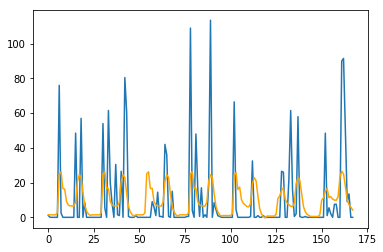

Normalized RMSE is: 0.8700268998749583


In [205]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(n_estimators=100)
gbrt.fit(df_train[feature_list], df_train.hot_water_flow)
predictions = gbrt.predict(df_test[feature_list])
predictions

plt.plot(df_test.hot_water_flow.values, label='Train')
plt.plot(predictions, label='Valid', color='orange')
plt.show()

print("Normalized RMSE is:", nrmse(df_test.hot_water_flow.values, predictions ))

#### 3.3.3 Random Forest Regression - Bootstrap Aggregation

Normalized RMSE is: 0.8487327234288701


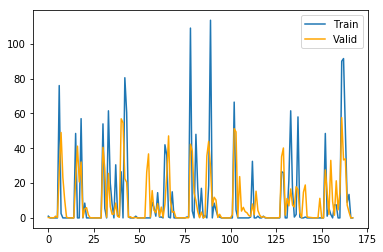

In [244]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=200)
rfr.fit(df_train[feature_list], df_train.hot_water_flow)
predictions = rfr.predict(df_test[feature_list])

plt.plot(df_test.hot_water_flow.values, label='Train')
plt.plot(predictions, label='Valid', color='orange')
plt.legend()

print("Normalized RMSE is:", nrmse(df_test.hot_water_flow.values, predictions ))

rfr_predictions = predictions

## 4. Results

### 4.1 Analysis of Models tried
We found that Random Forest Regressor gave the best results from the models tested above.

### 4.2 Visualizing results

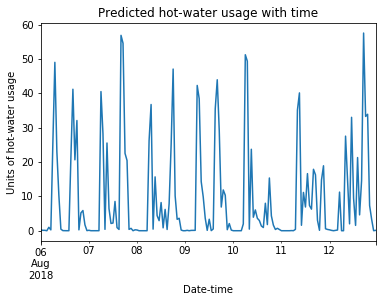

In [273]:
predictions = rfr_predictions

# Creating future date-time list
base = dt.datetime(2018, 8, 6, 0, 0, 0)
date_list = [base + dt.timedelta(hours=x) for x in range(0, 24*7)]

df_results=pd.DataFrame({"hot_water_prediction": predictions}, index=date_list)
df_results.head()

# Clipping any prediction value that is less than 0
def neg_clip(val):
    if val < 0:
        val = 0
    return val

df_results.hot_water_prediction = df_results.hot_water_prediction.apply(neg_clip)

ax = df_results.hot_water_prediction.plot();
ax.set_xlabel("Date-time");
ax.set_ylabel("Units of hot-water usage");
ax.set_title("Predicted hot-water usage with time");

### 4.2 Saving results

In [274]:
df_results = df_results.reset_index().rename(columns={"index":"date-time"})
df_results.to_csv("data/predictions.csv", index=False)
df_results.head()

,date-time,hot_water_prediction
0,2018-08-06 00:00:00,0.248662
1,2018-08-06 01:00:00,0.113437
2,2018-08-06 02:00:00,0.117674
3,2018-08-06 03:00:00,0.001000
4,2018-08-06 04:00:00,0.995671
